MonteCarlo simulation for geometricl efficiency estimation

In [1]:
import numpy as np
from scipy import special as sp
from scipy import constants as c
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\ricca\AppData\Local\Temp\ipykernel_15072\359663441.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
core_diam = 8.2*1e-6 # meters
lenght = 1 # meters
lam = 1555 * 1e-9 #meters

First we have to compute the number of photons coming out of the diode

In [3]:
P = 1.5*1e-3 #diode power
R0 = (P*lam)/(c.Planck*c.c) # photons per second

Then we have to account for 1m lenght of fiber

In [4]:
fiber_att = pow(10,(0.18/20))*lenght/1000 #W per m
R_in = R0*fiber_att*1/16*1e-8#rate of photons out of fiber in 1 ns
print("Total incoming photons in one SINGLE pulse are ca", int(R_in))

Total incoming photons in one SINGLE pulse are ca 7492


Airy diffraction formula

In [5]:
def airy(theta):
    a=core_diam
    k = 2*np.pi/lam
    x = k*a*np.sin(theta)
    return (2*sp.j1(x)/x)**2

Show plot of Airy formula

Text(0, 0.5, 'Airy')

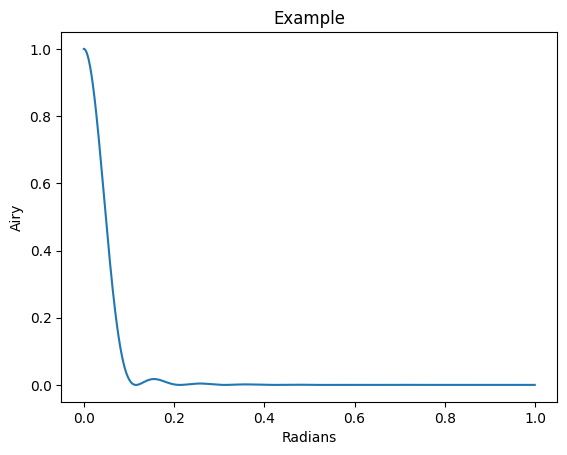

In [6]:
temp = np.arange(0.0001,1,0.001)
plt.plot(temp, airy(temp))
plt.title("Example")
plt.xlabel("Radians")
plt.ylabel("Airy")

In [7]:
z = 1
x = np.arange(0.000001,10,0.001)
ang = np.arctan(x/z)
R_out = R_in*airy(ang)

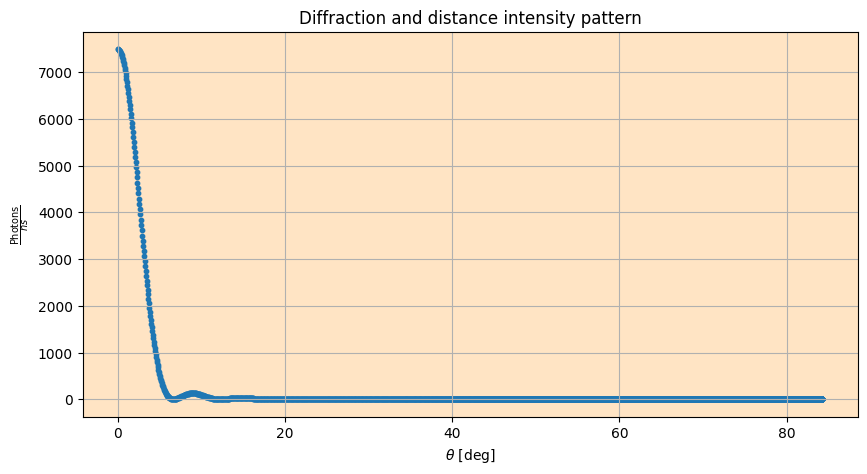

In [8]:
fig, axs = plt.subplots(figsize=(10,5))
plt.scatter(ang/np.pi*180, R_out, marker='o',s=10)
plt.title("Diffraction and distance intensity pattern")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$\frac{\text{Photons}}{ns}$")
plt.grid()
axs.set_facecolor('bisque')
#plt.colorbar(label="Radius dependence %", orientation="vertical") 


In [9]:
z = 1e3

Creating chip active area

In [10]:
x = {'xmin': [i * 1550 + 480 for i in range(8)], 'xmax': [i * 1550 + 730 for i in range(8)]} 

xactives = [(x['xmin'][i],x['xmax'][i]) for i in range(len(x['xmin']))]
yactives = [(1270,2030),(2230,2290)]

yplus = {'ymin': 2230, 'ymax': 2990}
yneg = {'ymin': 1270, 'ymax': 2030}
y = [1270,2030, 2230, 2990]

In [11]:
Ttime = 0.01 #total acquisition time in seconds
acq = np.arange(0,Ttime,30*1e-6)
print(len(acq))

N = int(R_in)

dic = {"sig_num": [],"theta": [], "counts": []}

for j in range(len(acq)):
    
    theta = []
    count = np.zeros(8)

    for n in range(N):
        xax = np.random.uniform(low=0, high=max(x['xmax'])+250)
        yax = np.random.uniform(low=0, high=4265)
        for i in range(8):
            if (x['xmin'][i]<xax and xax<x['xmax'][i]) and ((yneg['ymin']<yax and  yax<yneg['ymax']) or
             (yplus['ymin']<yax and yax<yplus['ymax'])):
                count[i] += 1
                theta.append(90-180/np.pi*np.arctan(np.sqrt(xax**2 + yax**2)/z))
    
    dic["counts"].append(count)
    dic["theta"].append(theta)
    dic["sig_num"].append(j)

334


In [26]:
df = pd.DataFrame(dic)

Histogram of counts before airy correction

C:\Users\ricca\AppData\Local\Temp\ipykernel_15072\2949047808.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(figsize=(10,5))


KeyboardInterrupt: 

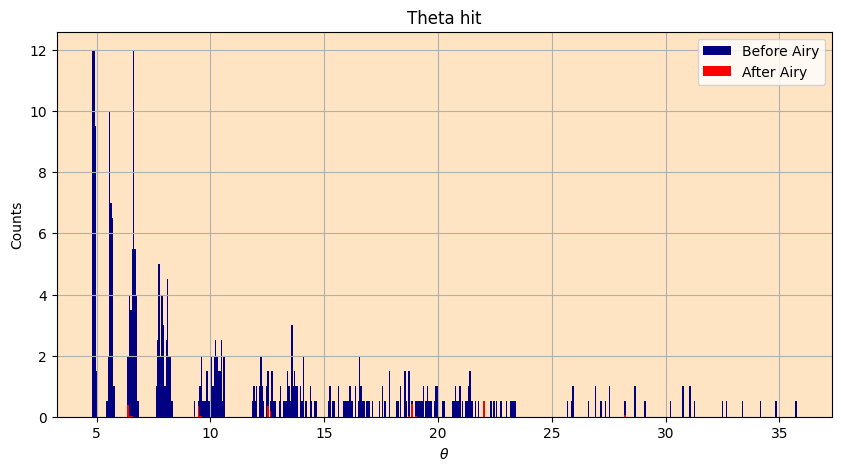

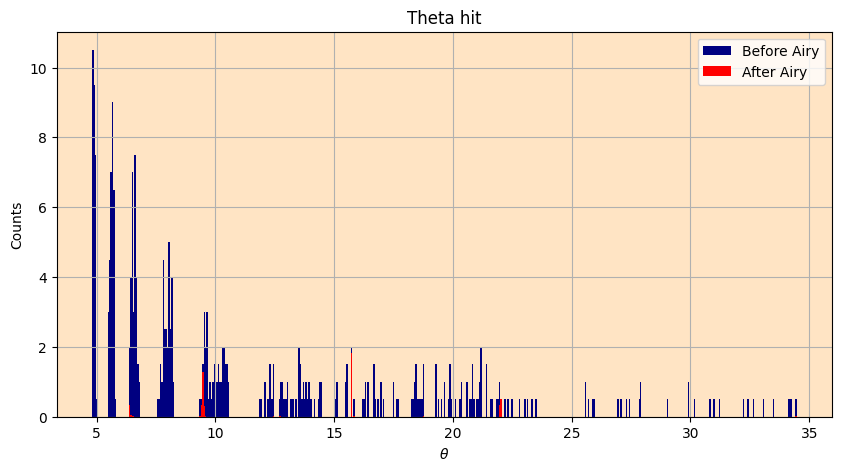

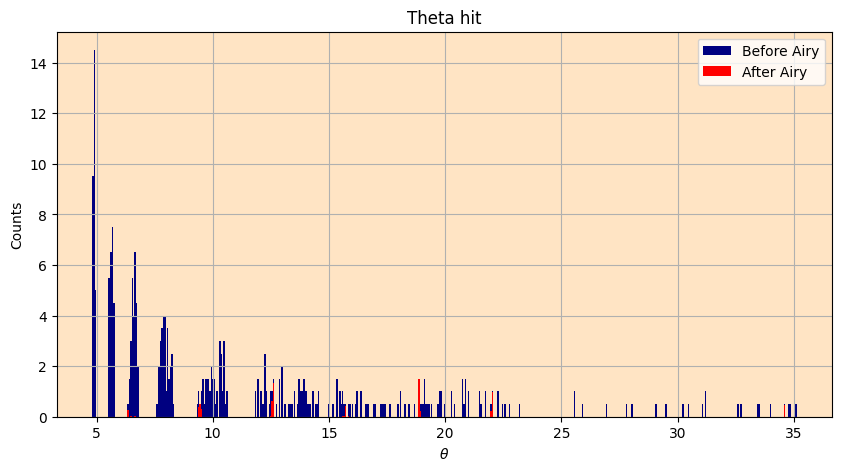

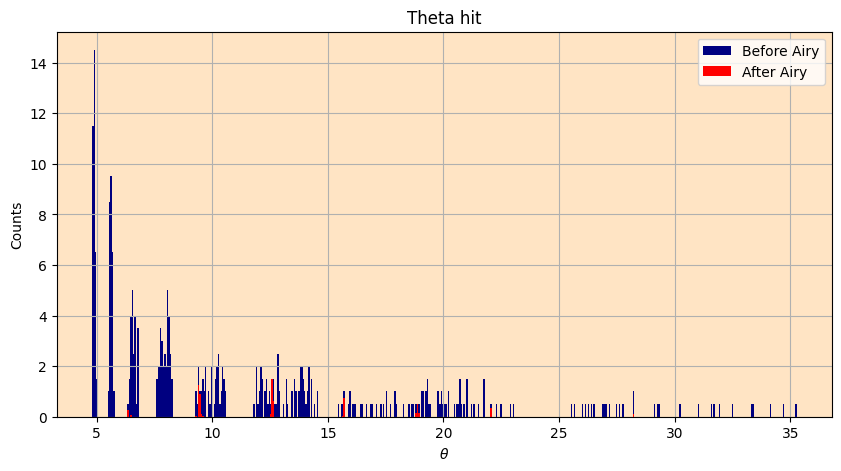

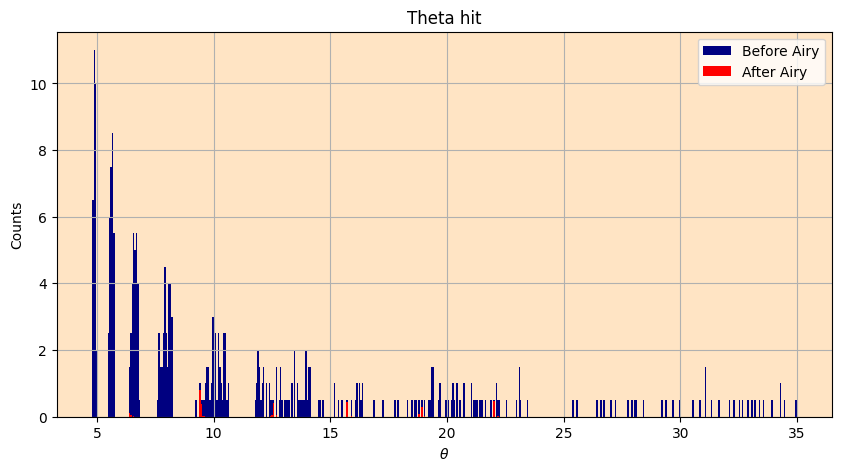

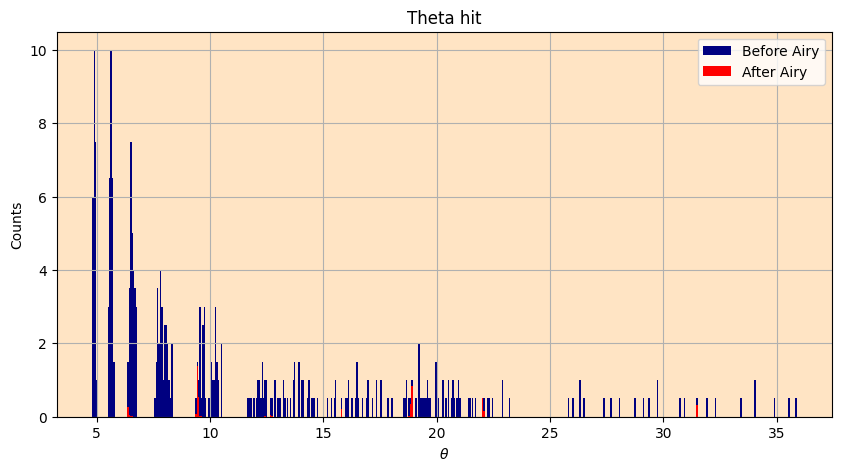

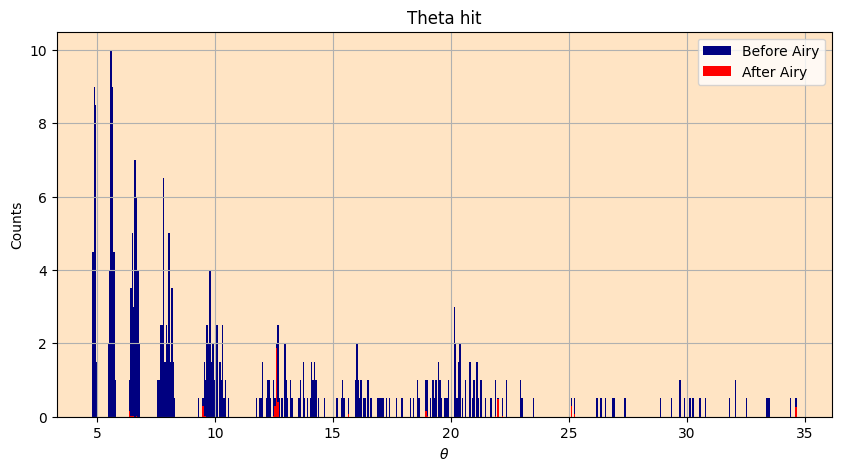

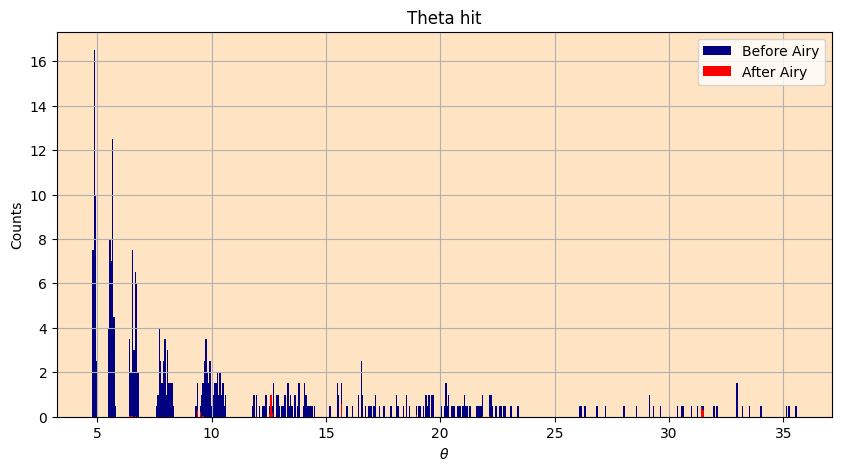

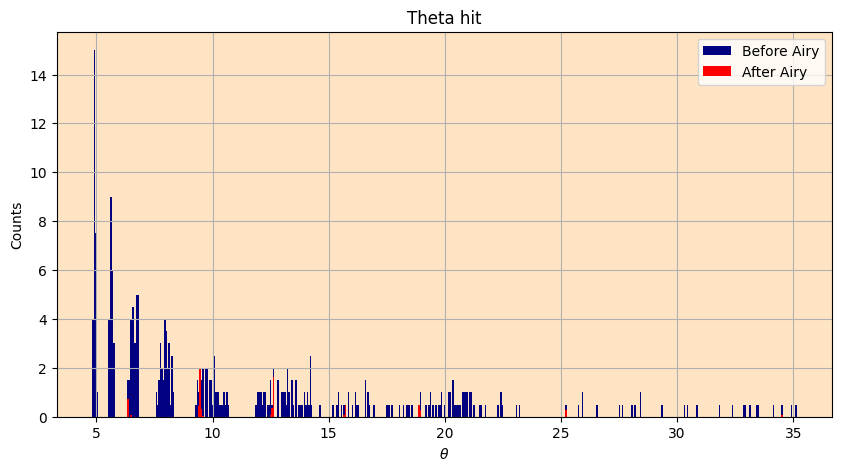

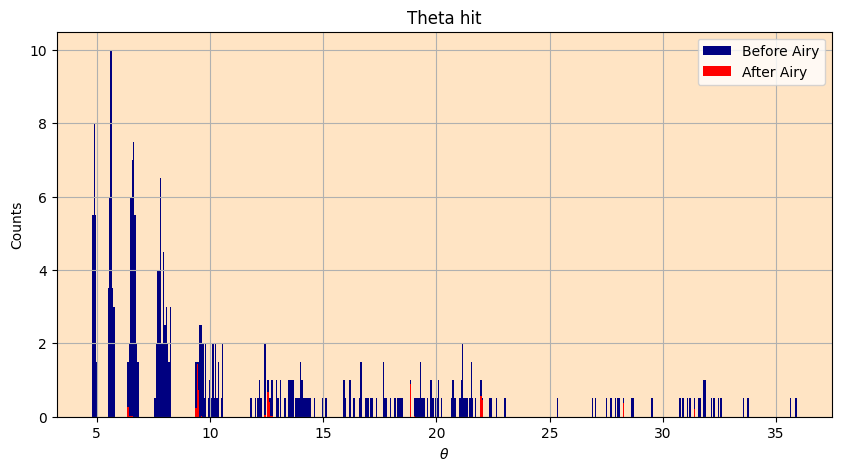

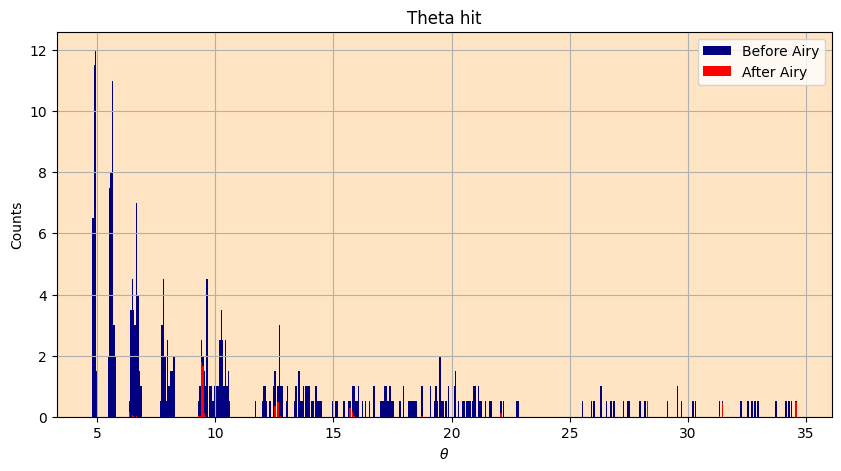

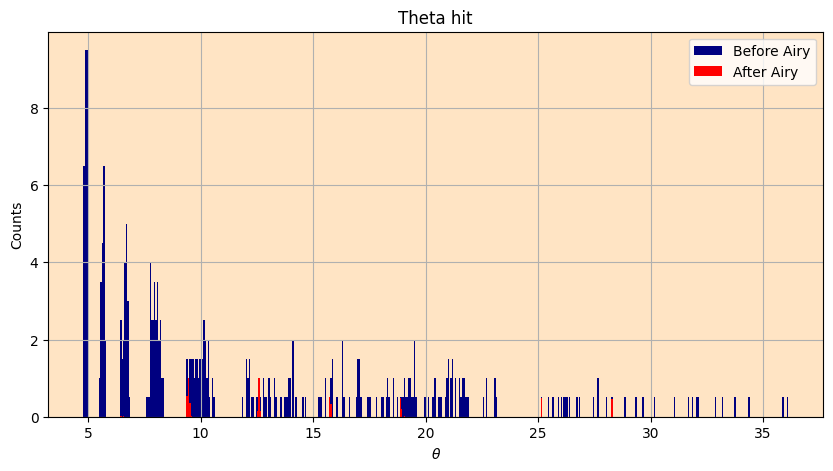

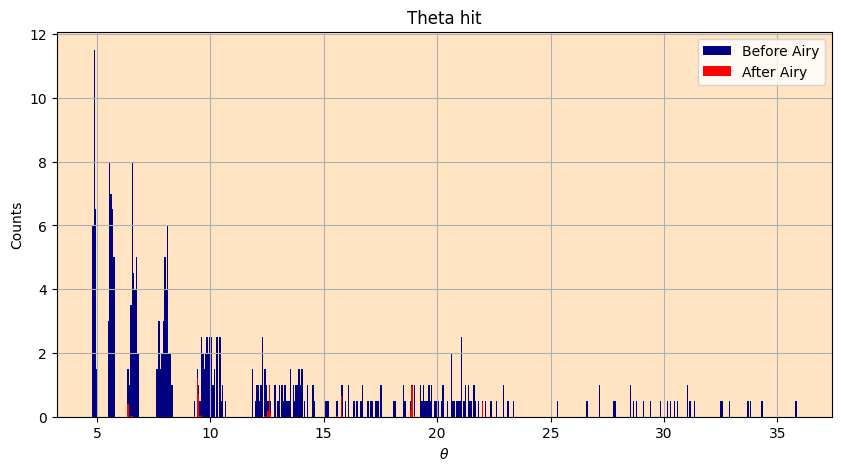

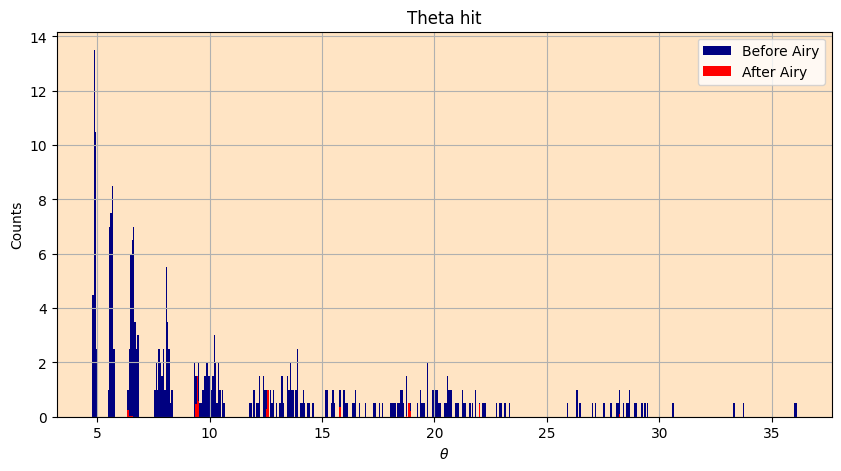

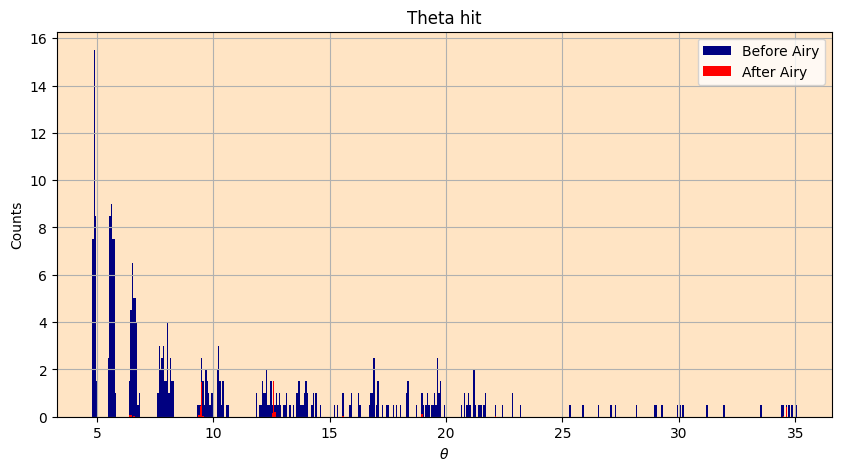

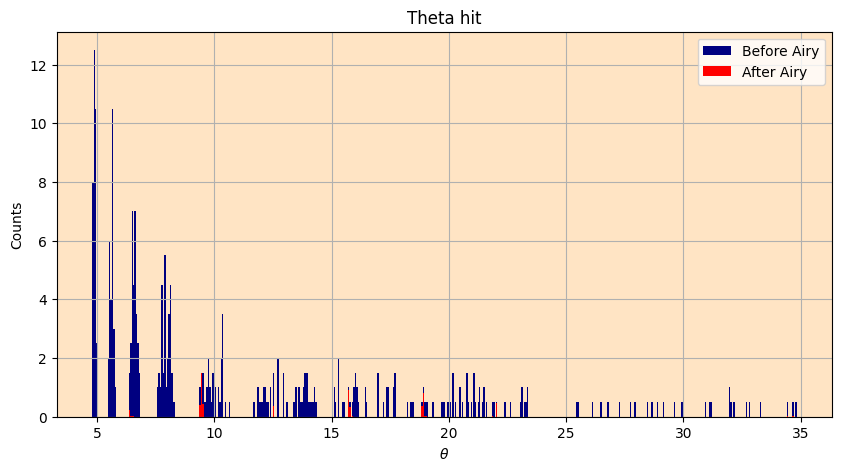

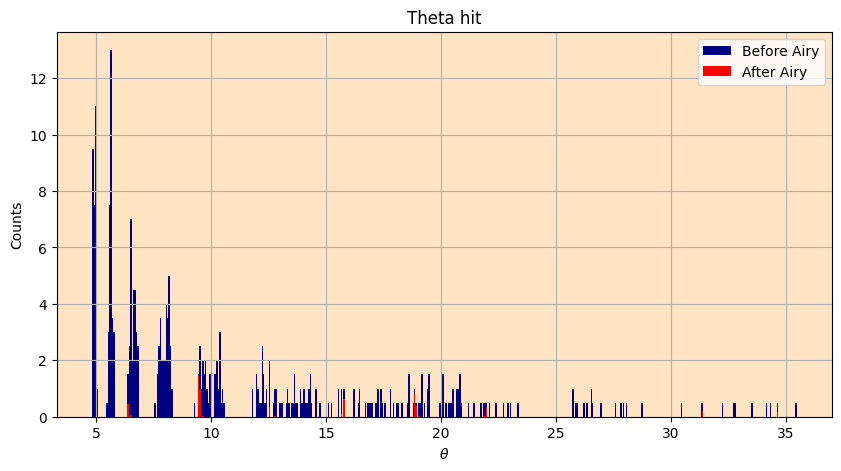

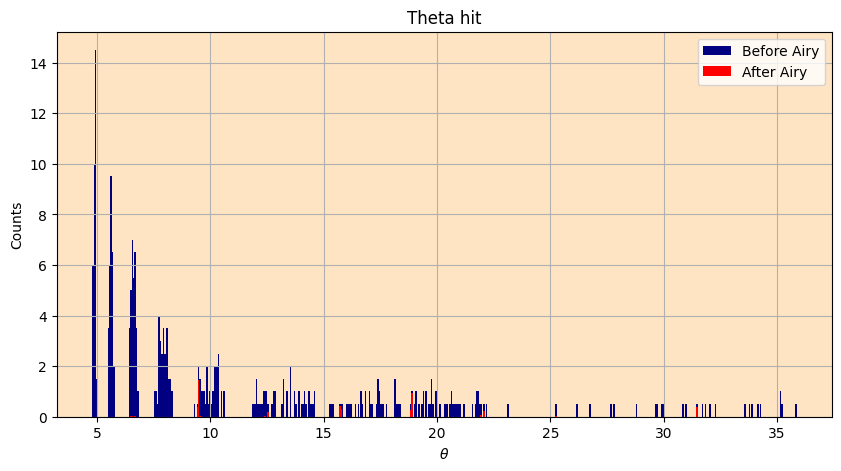

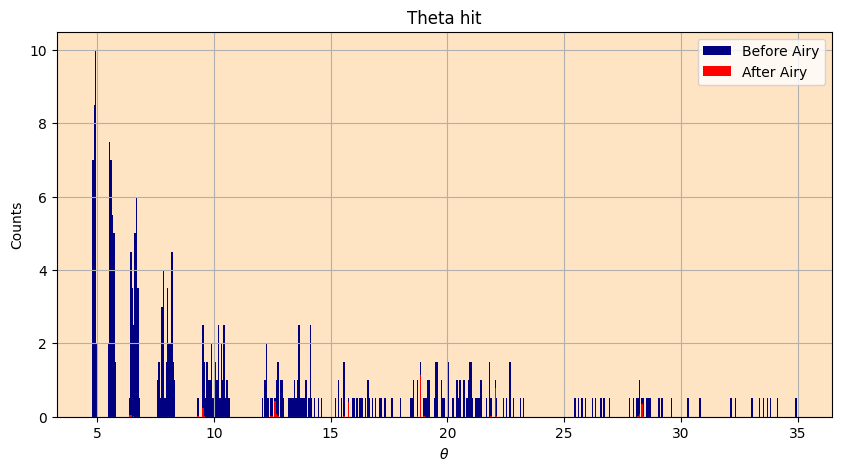

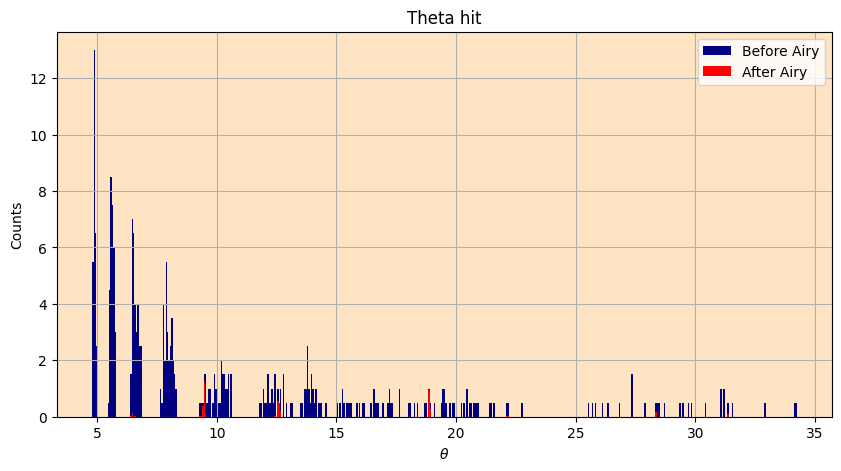

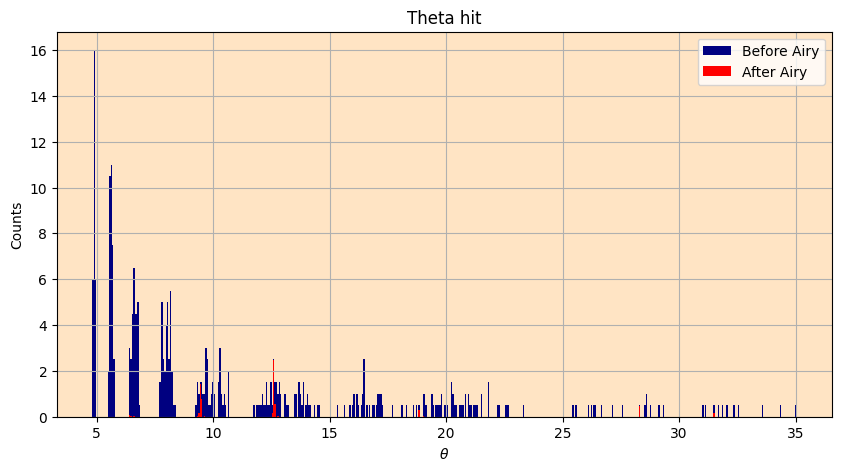

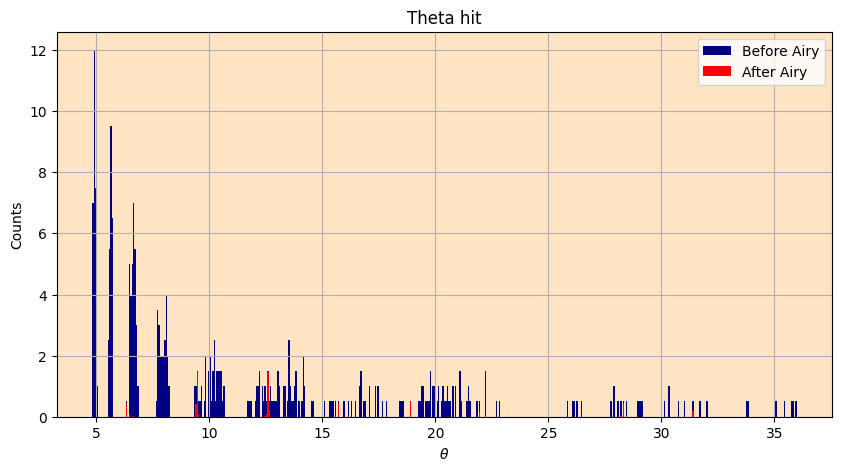

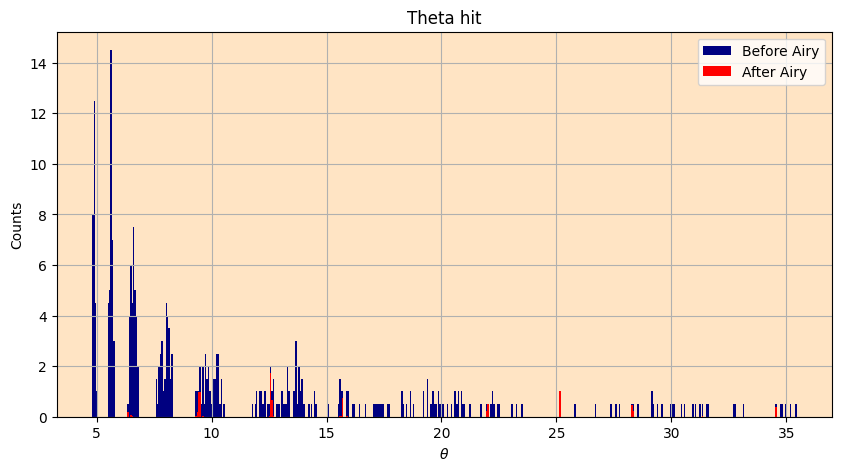

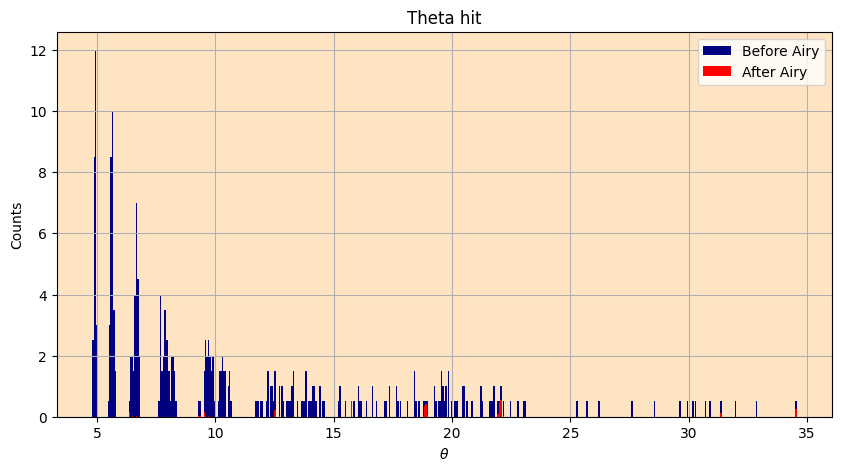

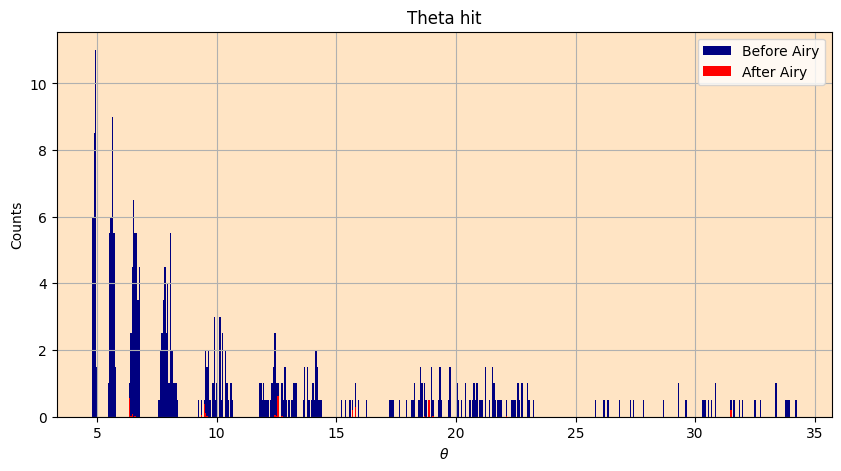

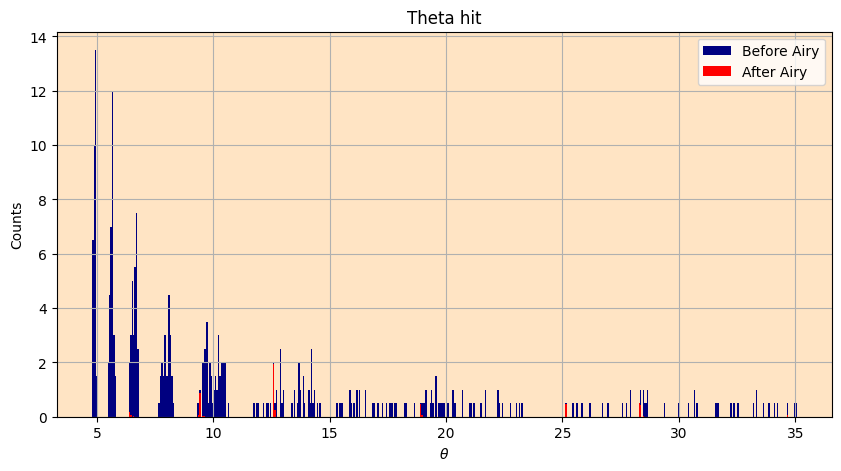

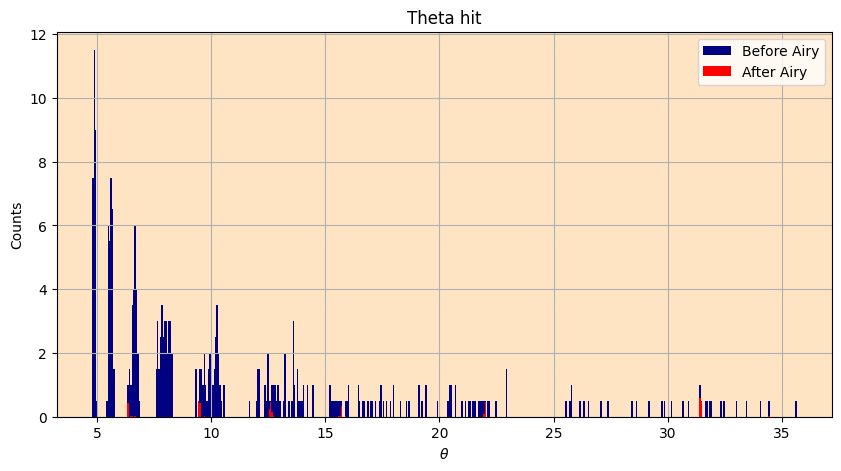

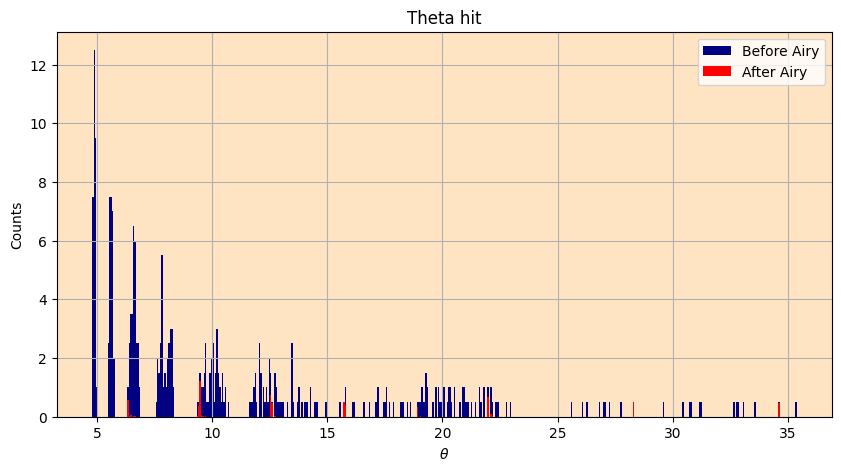

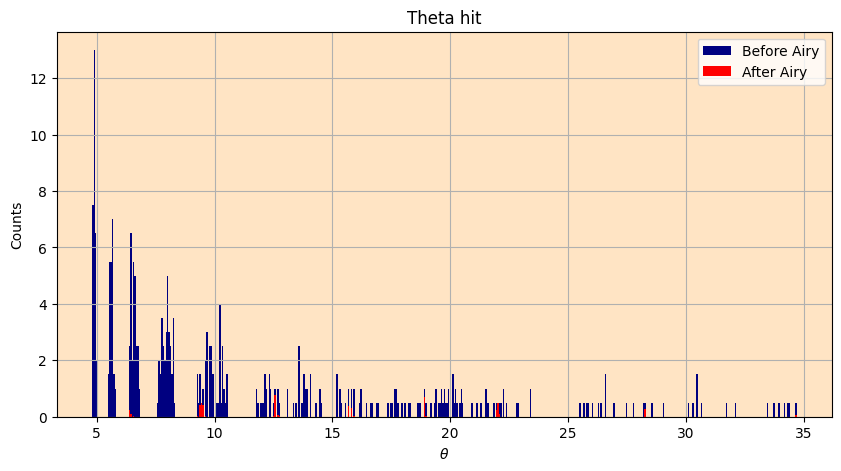

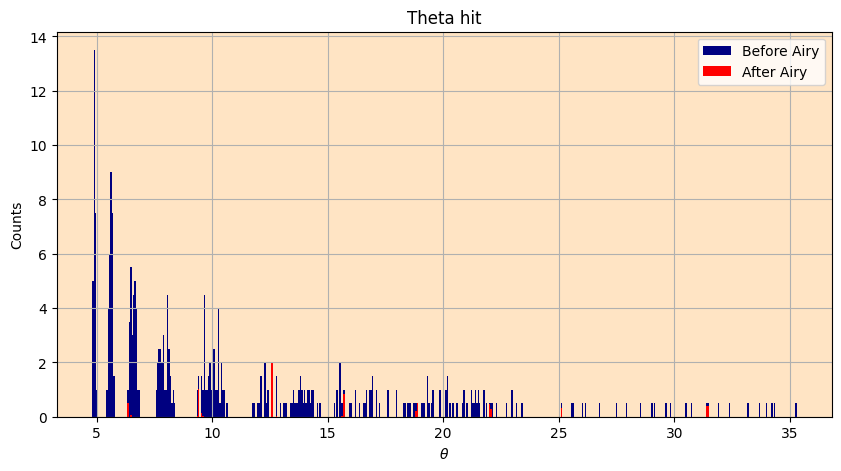

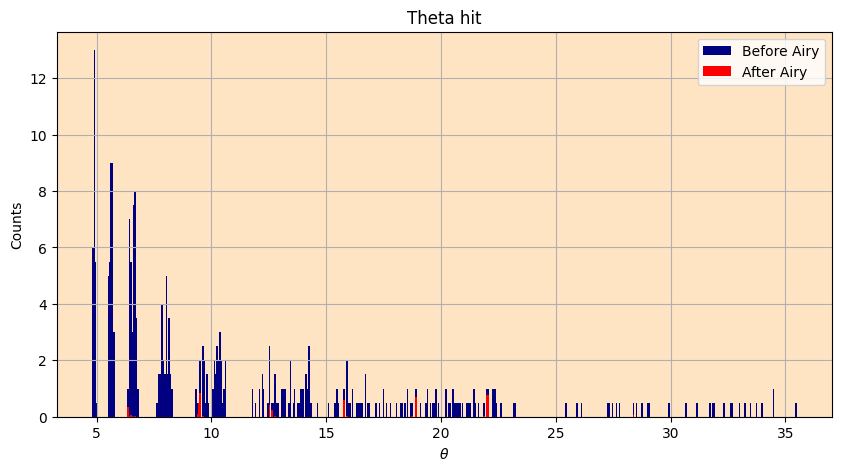

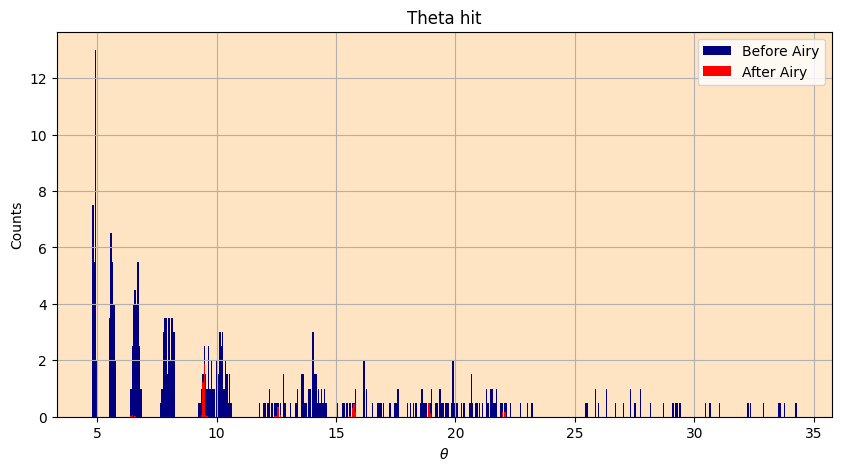

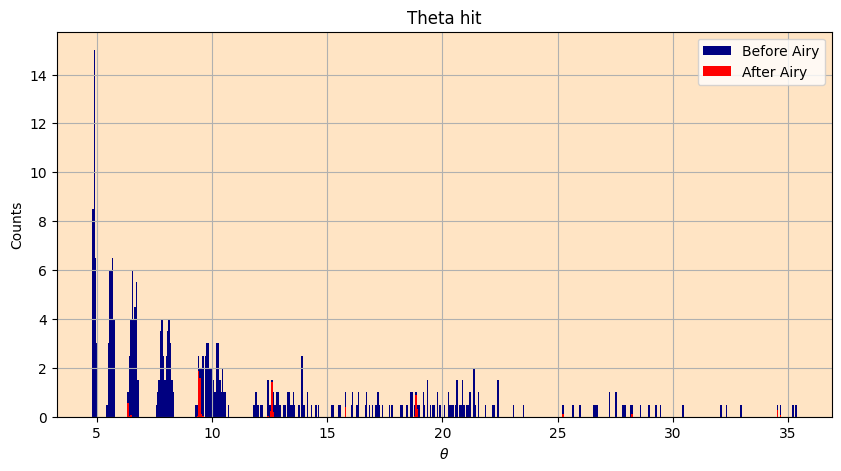

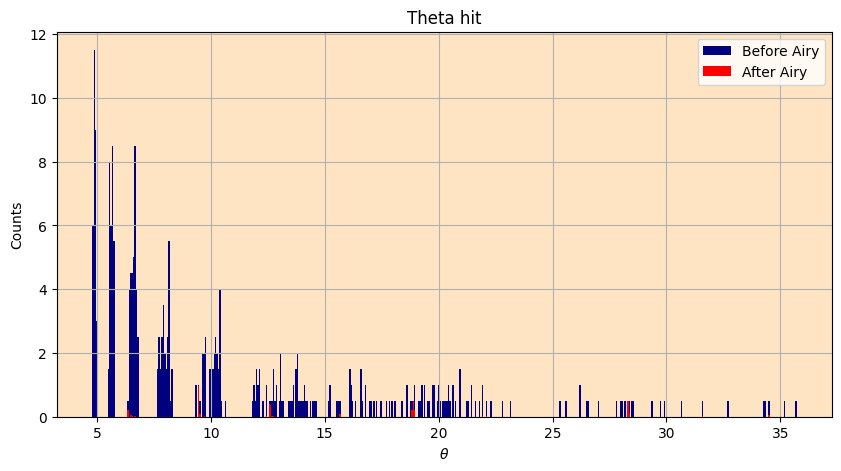

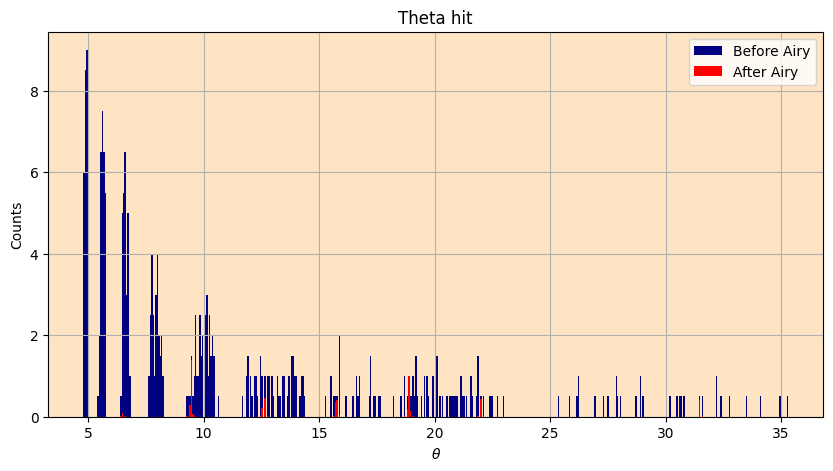

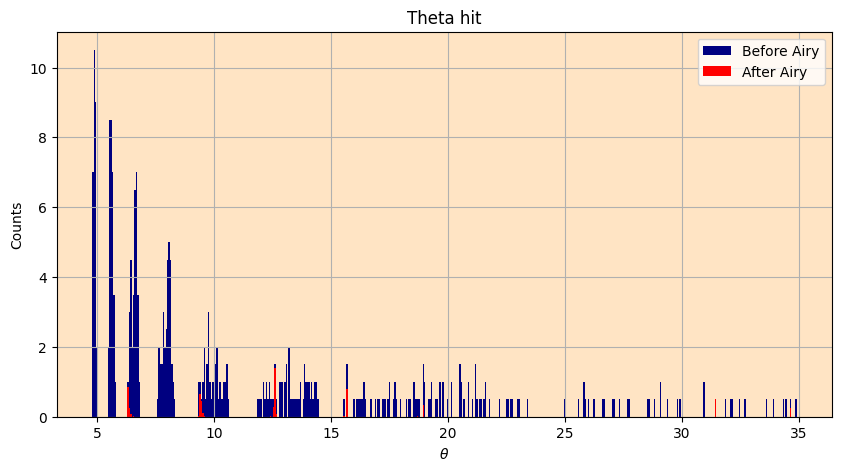

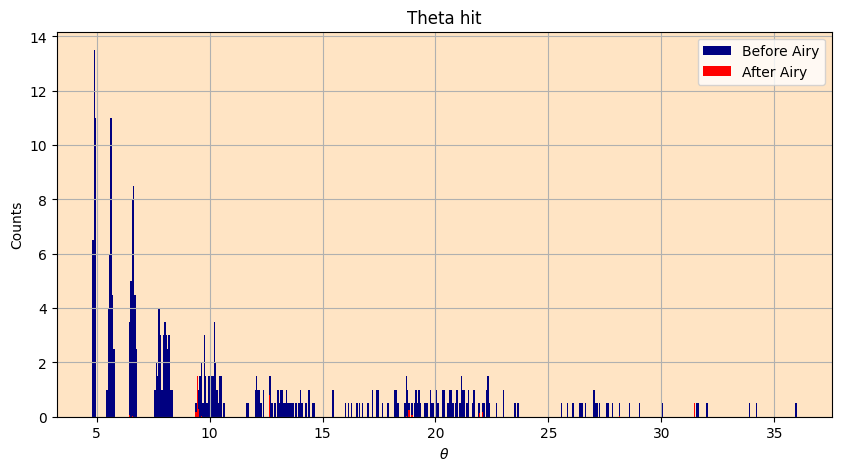

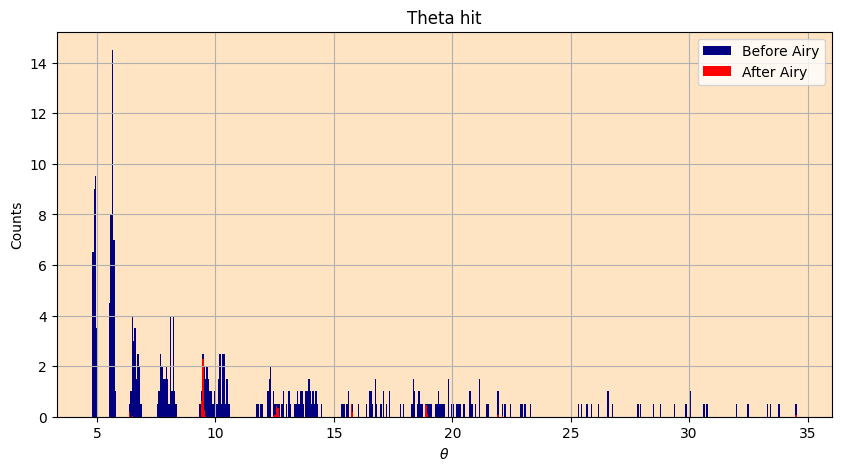

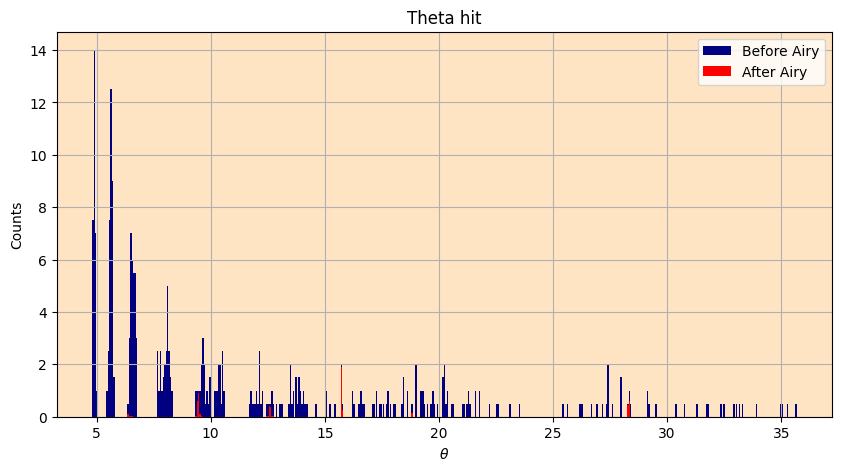

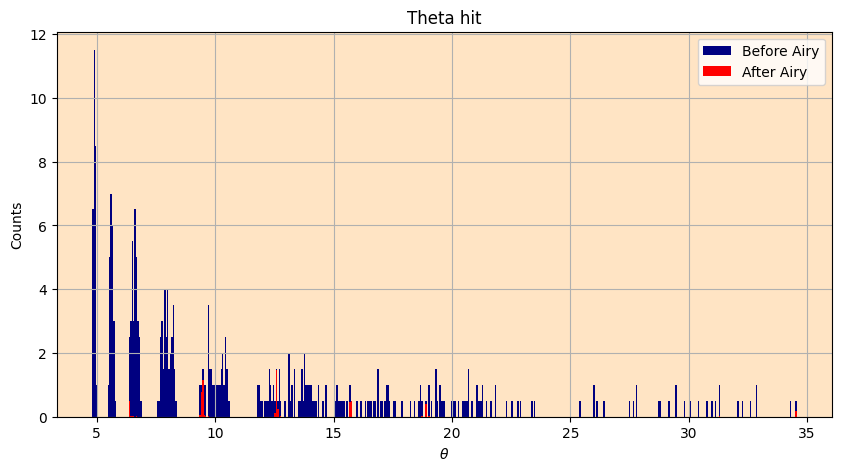

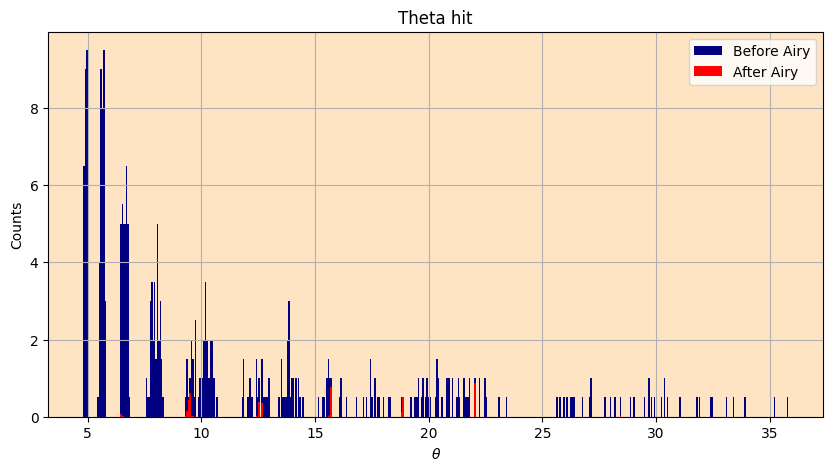

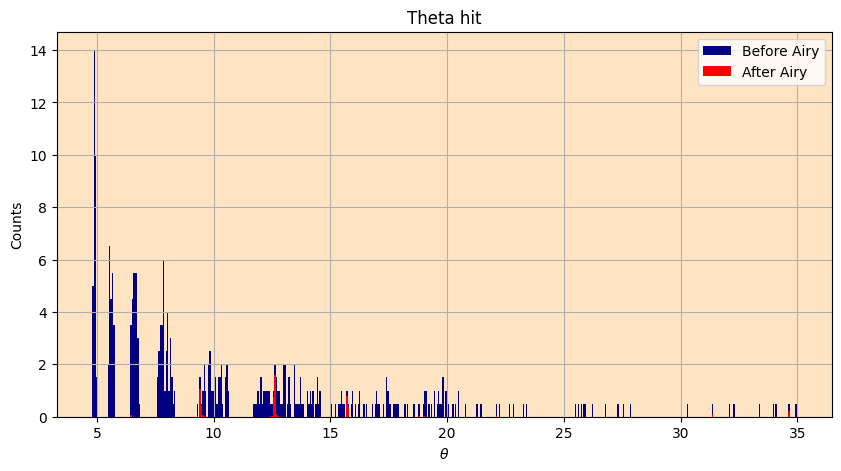

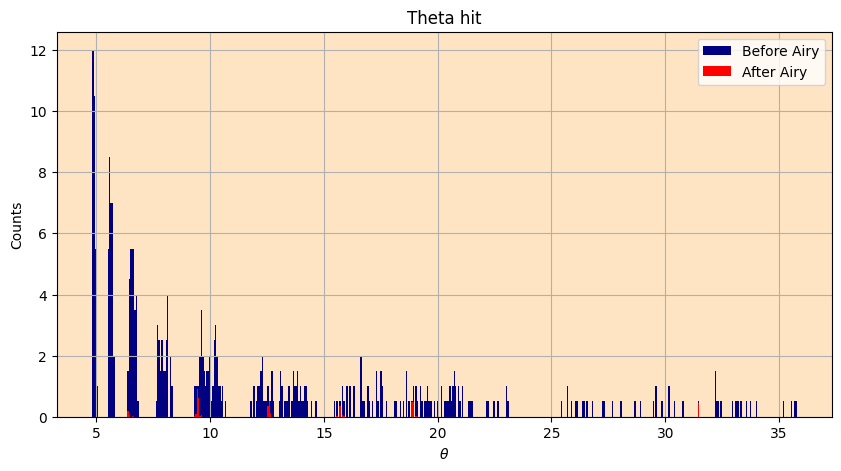

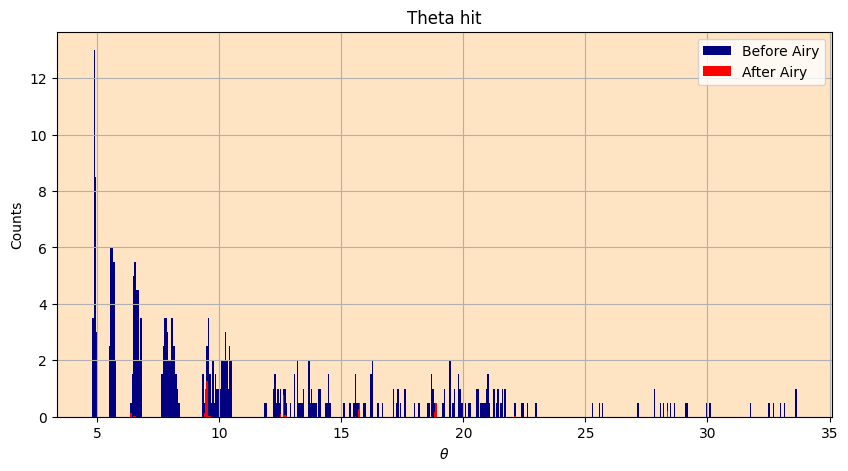

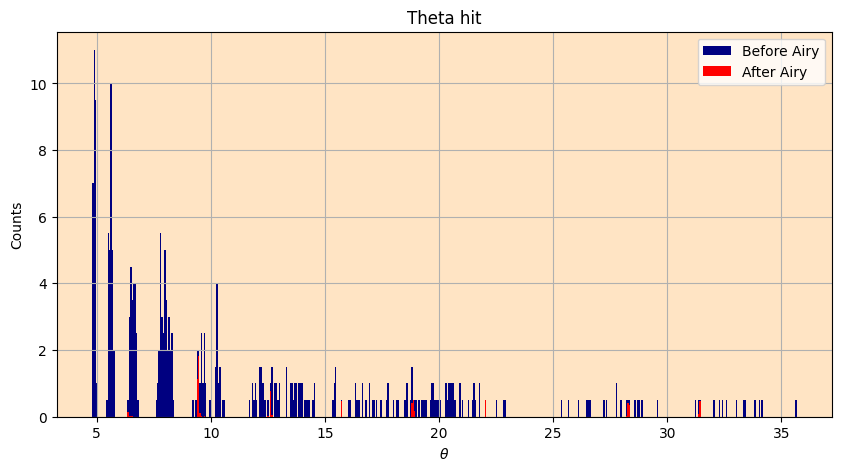

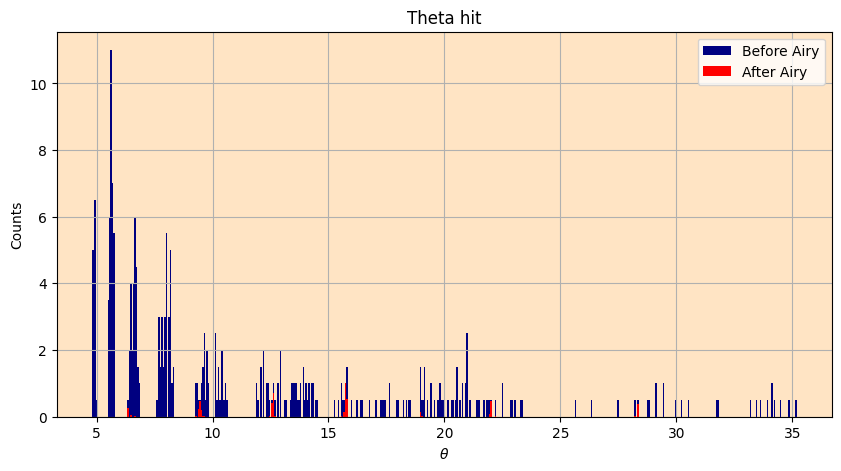

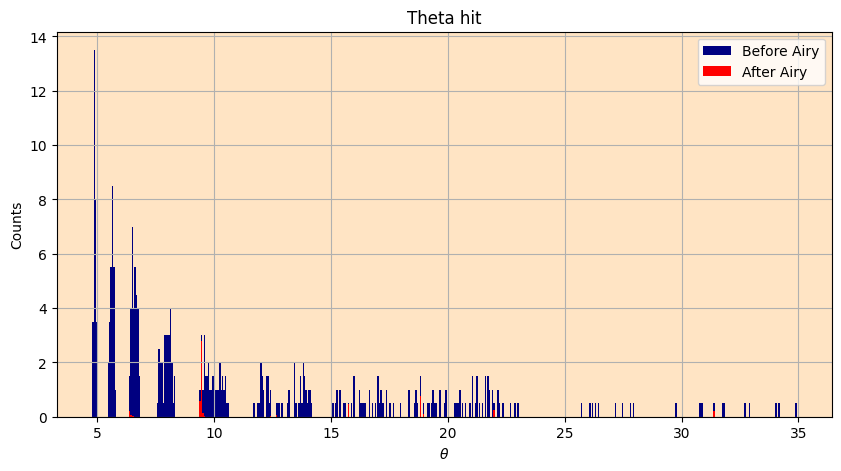

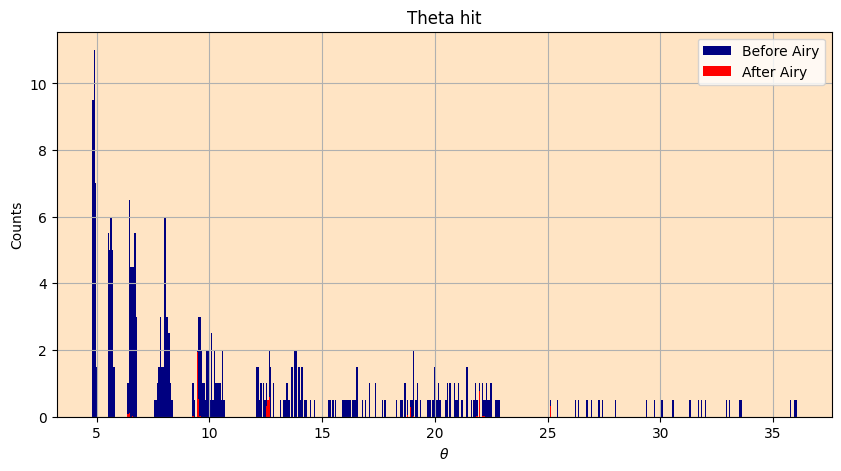

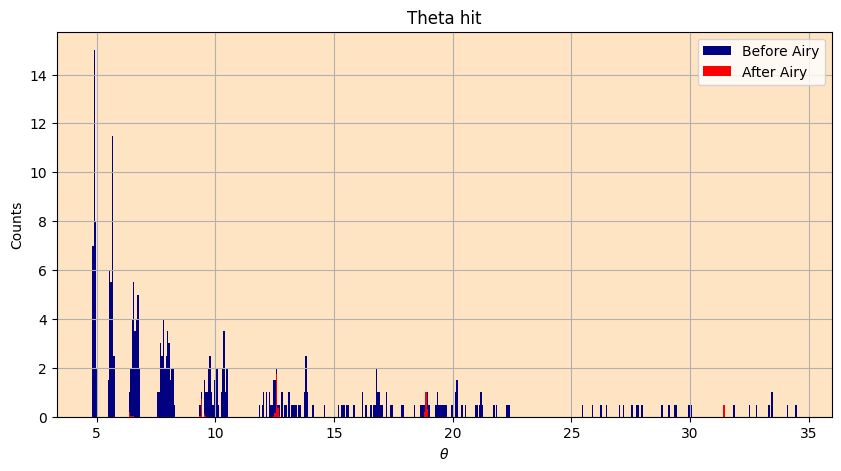

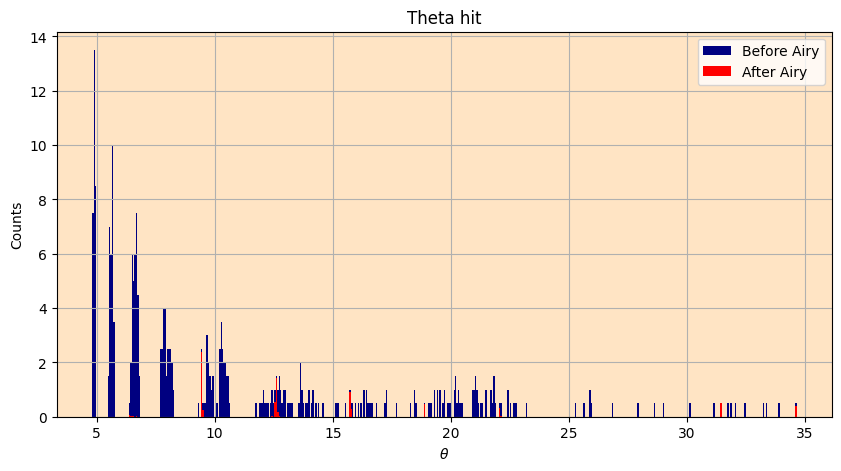

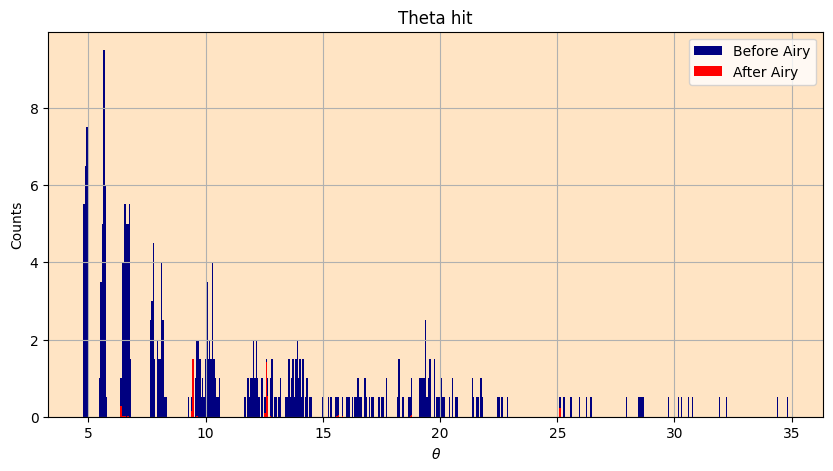

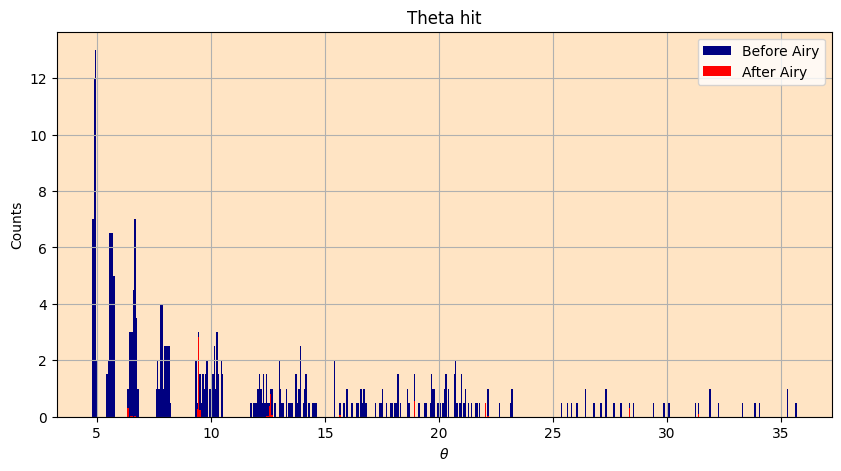

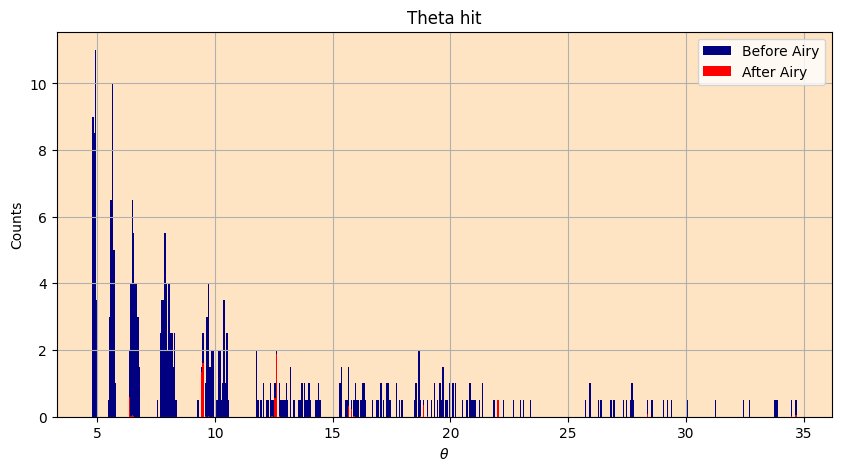

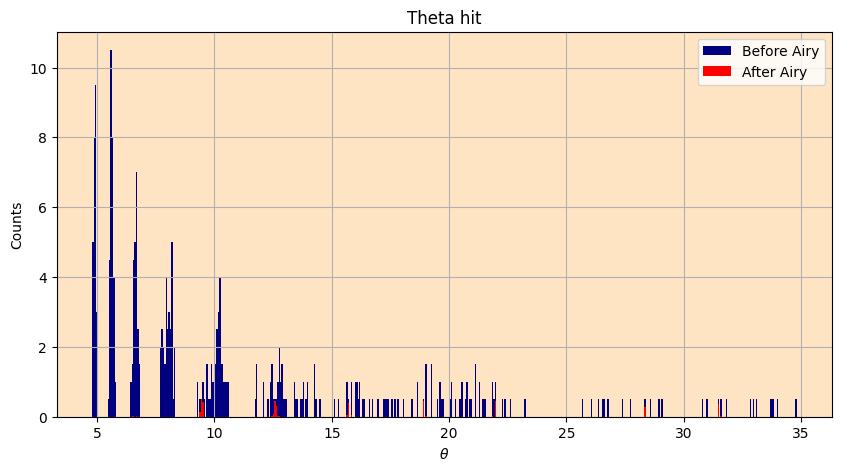

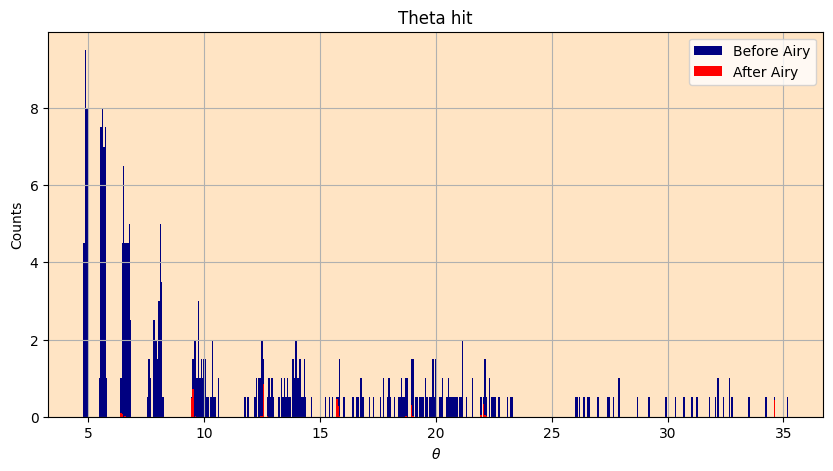

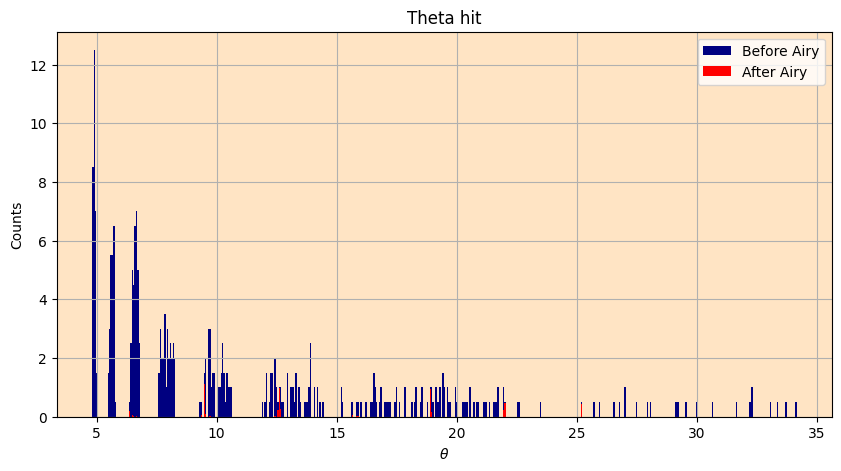

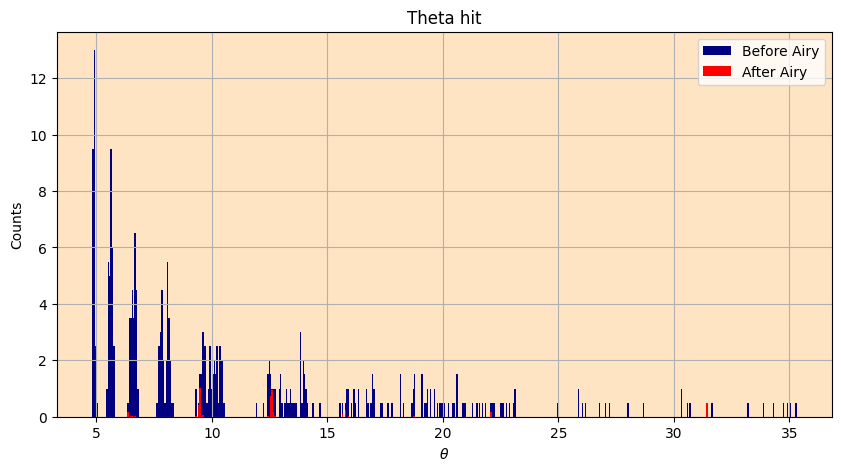

Error in callback <function flush_figures at 0x0000021873DDE2A0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [27]:
from datetime import date

for i in range(len(df["sig_num"])):
    datab = np.array(df["theta"][i])
    bin_countb = 500
    binsb = np.linspace(min(df["theta"][i]), max(df["theta"][i]), bin_countb)
    data_entriesb, binsb = np.histogram(datab, bins=binsb)#, bins=bins)
    binscentersb = np.array([0.5 * (binsb[j] + binsb[j+1]) for j in range(len(binsb)-1)])

    heights = []
    for (height,theta) in zip(data_entriesb,binsb):
        heights.append(height*airy(theta))
        

    fig, axs = plt.subplots(figsize=(10,5))
    axs.set_facecolor("bisque")
    plt.bar(binscentersb, np.array(data_entriesb)/2, width=binsb[1] - binsb[0], color='navy', label=r'Before Airy');
    plt.bar(binscentersb, np.array(heights)/2, width=binsb[1] - binsb[0], color='red', label=r'After Airy');
    plt.xlabel(r"$\theta$")
    plt.xticks()
    plt.ylabel(r'Counts')
    plt.title(r'Theta hit')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(r"F:\\LabIV\\QTLab2324\\IRSource\\MC-Geometry\\png\\simulation_"+str(i)+"_"+str(date.today())+".png")

In [28]:
print("Simulated Efficiency = ", df["counts"].sum()/(R_in*len(acq)))

Simulated Efficiency =  [0.75113351 0.7491355  0.74653808 0.75081383 0.75572894 0.75940529
 0.757687   0.75009454]
